# 0.0 Imports

In [3]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, HTML
from scipy import stats

## 0.1 Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set
    

    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [6]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
484718,479,3,2014-04-23,9897,1297,1,0,0,0,a,a,320.0,12.0,2005.0,1,9.0,2011.0,"Feb,May,Aug,Nov"
375095,398,2,2014-08-05,5452,619,1,1,0,1,c,c,1540.0,NaN,NaN,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
539447,573,3,2014-03-05,4792,378,1,1,0,1,a,a,1190.0,11.0,2012.0,1,36.0,2013.0,"Jan,Apr,Jul,Oct"
518700,1011,1,2014-03-24,6814,915,1,0,0,0,a,c,490.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
77489,555,6,2015-05-23,4272,409,1,0,0,0,d,a,1560.0,1.0,2014.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec"


# 1.0 Descrição dos Dados

In [8]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
        'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
        'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols))

df1.columns = cols_new

## 1.2 Data Dimension

In [10]:
df1.shape

(1017209, 18)

## 1.3 Data Types

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [12]:
#alterando a colunda data de object para tipo data

df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
#competition_distance  

df1['competition_distance'] = (df1['competition_distance'].
                               apply(lambda x: 200000.0 if math.isnan(x) else (x)))


#competition_open_since_month
df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].
                                                 month if math.isnan(x['competition_open_since_month'])
                                                 else x['competition_open_since_month'], axis=1))

#competition_open_since_year
df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].
                                                 year if math.isnan(x['competition_open_since_year'])
                                                 else x['competition_open_since_year'], axis=1))

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                               else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                               else x['promo2_since_year'], axis=1)

#promo_interval

month_map = { 1: 'Jan', 2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May', 6: 'Jun',  
             7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct',  11: 'Nov',  12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = (df1[['promo_interval', 'month_map']].
                   apply(lambda x: 0 if x['promo_interval'] == 0 
                         else 1 if x['month_map'] in x['promo_interval'].split(',') 
                         else 0, axis=1))


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6 Change Types

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'datetime64[ns]', 'float64'])

###  1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T



# Dispersion - std, min, max, ran, skew, curtusis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()

m.columns = ( [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] )
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.1 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

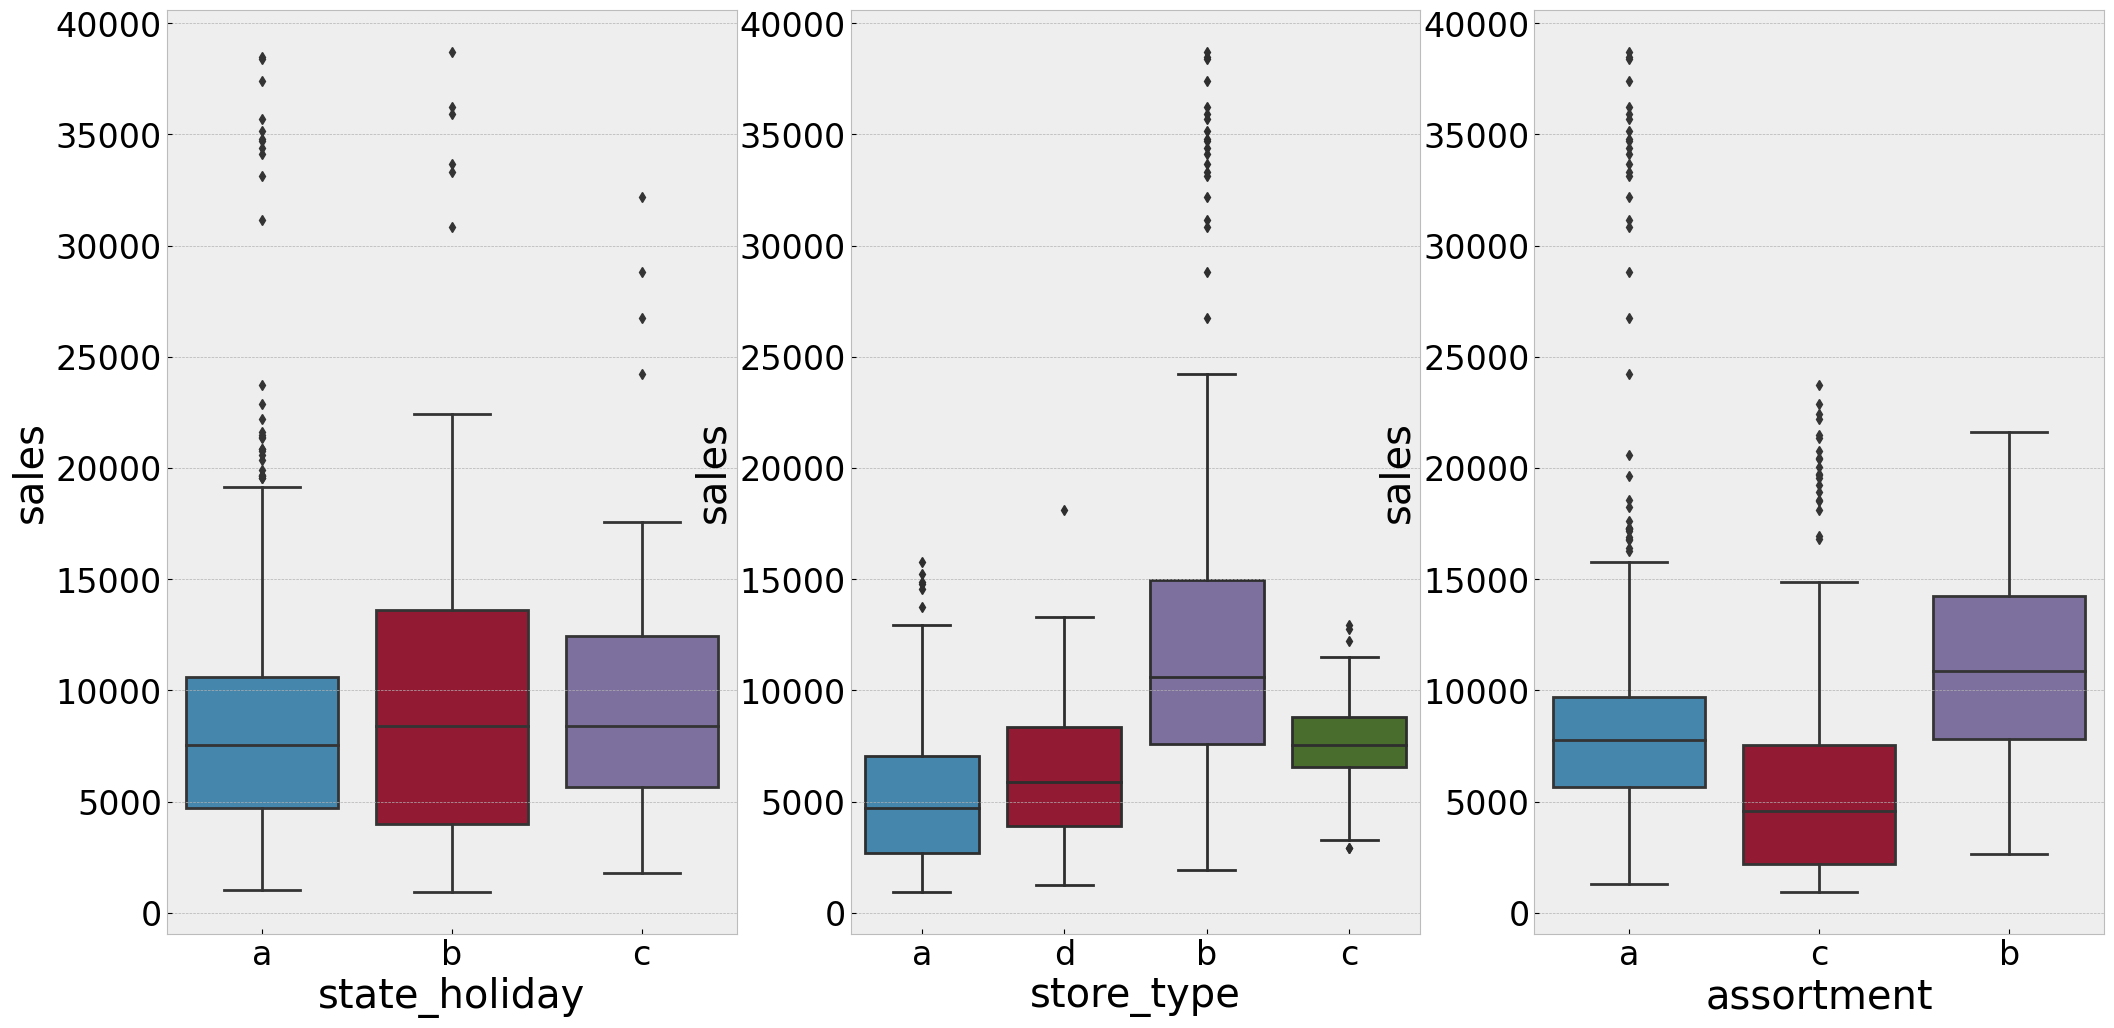

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]


plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Featuring Engineering

In [23]:
df2 = df1.copy()

## 2.1 Mapa Mental das Hipóteses


## 2.1.1 Criação das Hipóteses

## 2.2 Lista Final das Hipóteses

### H1. Lojas com maior sortimentos deveriam vender mais
### H2. Lojas com competidores mais próximos deveriam vender menos.
### H3. Lojas com competidores à mais tempo deveriam vendem mais.
### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### H5. Lojas com mais dias de promoção deveriam vender mais.
### H6. Lojas com mais promoções consecutivas deveriam vender mais.
### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
### H8. Lojas deveriam vender mais ao longo dos anos.
### H9. Lojas deveriam vender mais no segundo semestre do ano.
### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
### H11. Lojas deveriam vender menos aos finais de semana
### H12. Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = (df2.apply(lambda x: datetime.datetime
                                      (year=x['competition_open_since_year'],
                                       month=x['competition_open_since_month'],
                                       day=1), axis=1))


#df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

df2['competition_time_month'] = (df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)




# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = (df2['promo_since'].
                      apply(lambda x: datetime.datetime.
                            strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)))


df2['promo_time_week'] = df2['competition_time_month'] = (((df2['date'] - df2['promo_since']) / 7).
                                 apply(lambda x: x.days).astype(int))



# assortment



df2['assortment'] = (df2['assortment'].
                     apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended'))

# state_holiday

df2['state_holiday'] = (df2['state_holiday'].
                     apply(lambda x: 'public_holiday' if x == 'a' 
                           else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' 
                           else 'regular'))


df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular,regular,regular,regular,regular
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [25]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [26]:
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0 )]

## 3.2 Seleção das Colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise Exploratória de Dados

In [28]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

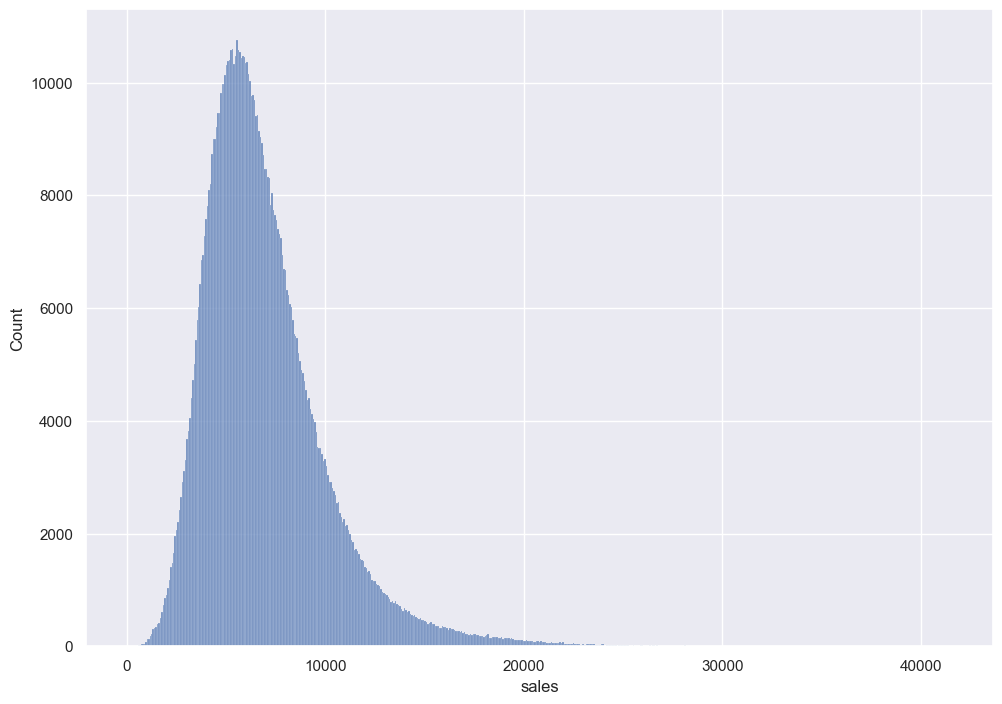

In [31]:
sns.histplot( df4['sales']);

### 4.1.2 Numerical Variable

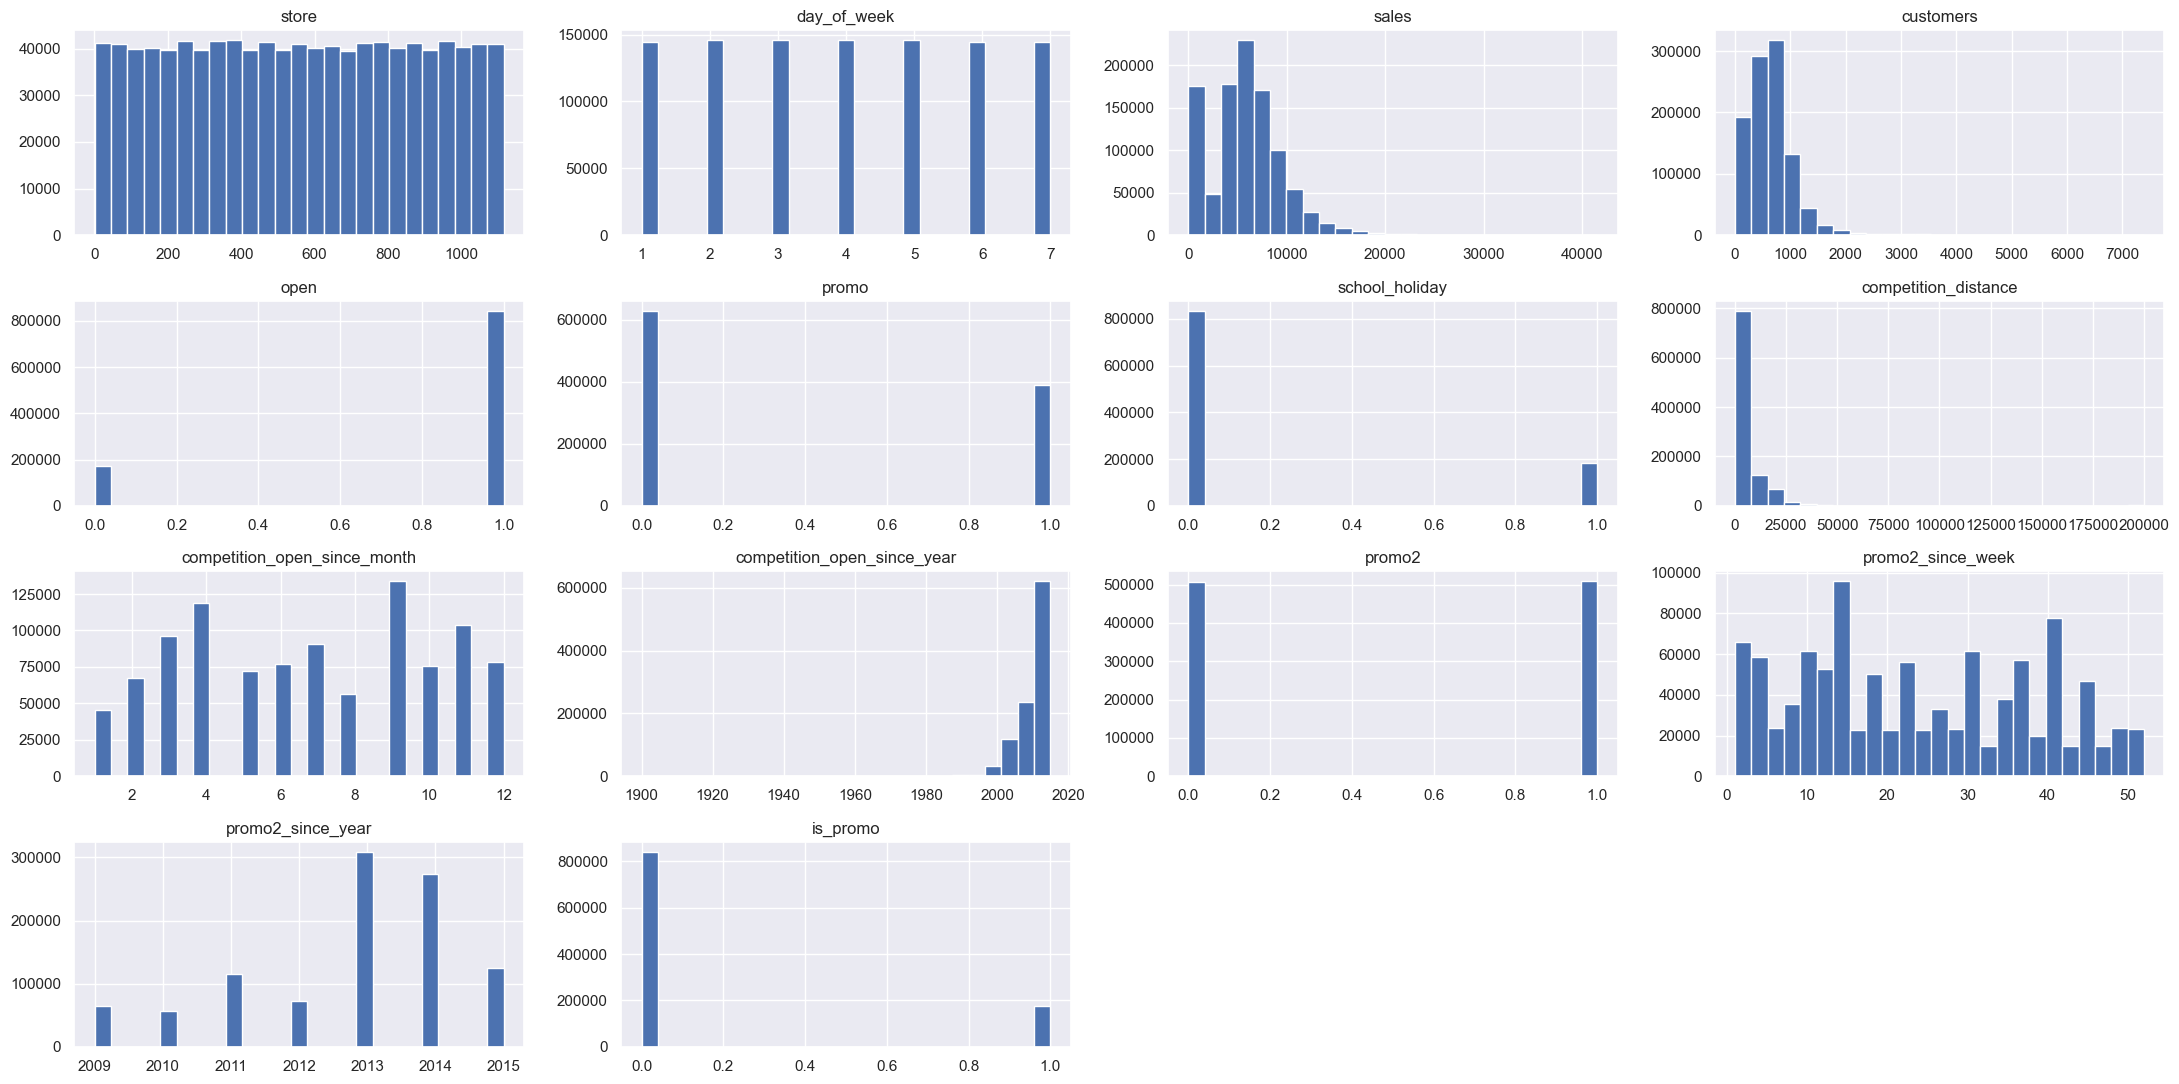

In [32]:
num_attributes.hist(bins=25, figsize=(22,11))
plt.tight_layout();

### 4.1.3 Categorical Variable¶

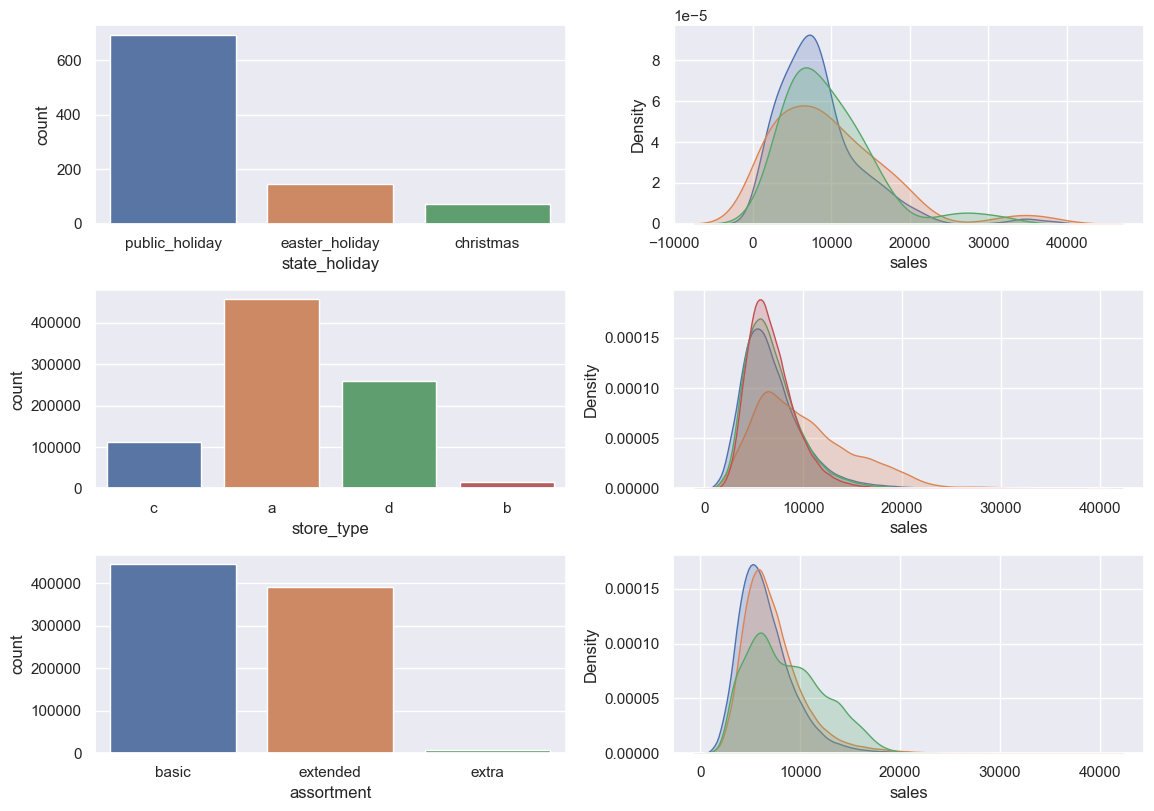

In [35]:
#state_holiday

plt.subplot(3, 2, 1)
aux4 = df4[df4['state_holiday'] != 'regular']
sns.countplot( data = aux4, x='state_holiday' )
sns.set(rc={'figure.figsize':(8.8,8.27)})
plt.tight_layout();

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.tight_layout();



#store_type

plt.subplot(3, 2, 3)
sns.countplot( data = df4, x='store_type' )
sns.set(rc={'figure.figsize':(8.8,8.27)})
plt.tight_layout();

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.tight_layout();

#assortment

plt.subplot(3, 2, 5)
sns.countplot( data = df4, x='assortment' )
sns.set(rc={'figure.figsize':(8.8,8.27)})
plt.tight_layout();

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.tight_layout();

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais

- **FALSA** Lojas com maior sortimento vendem menos

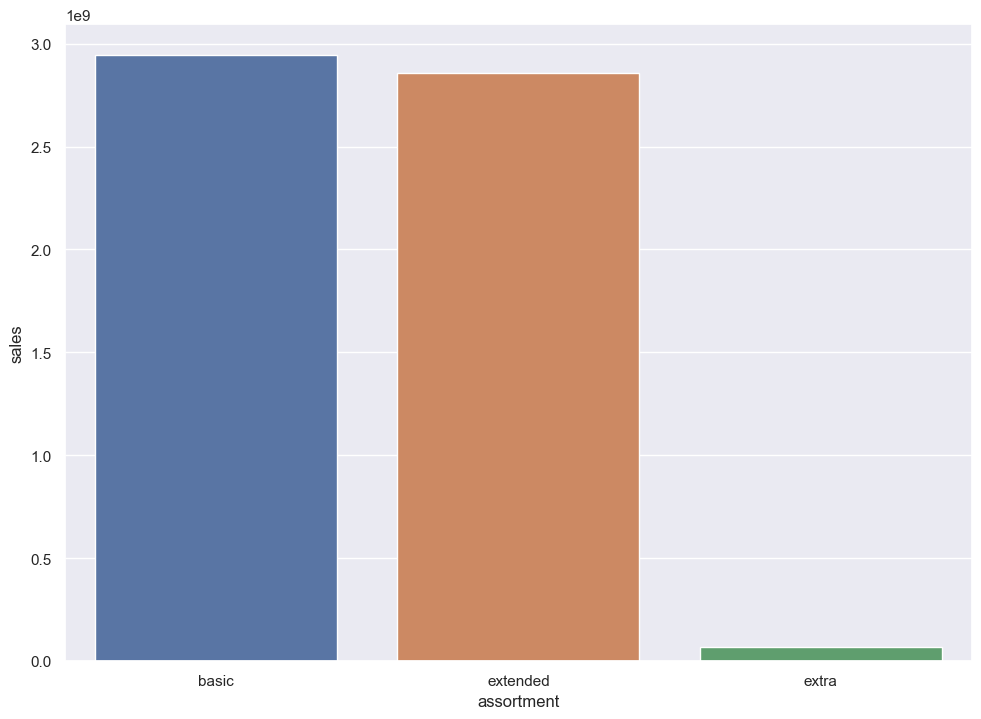

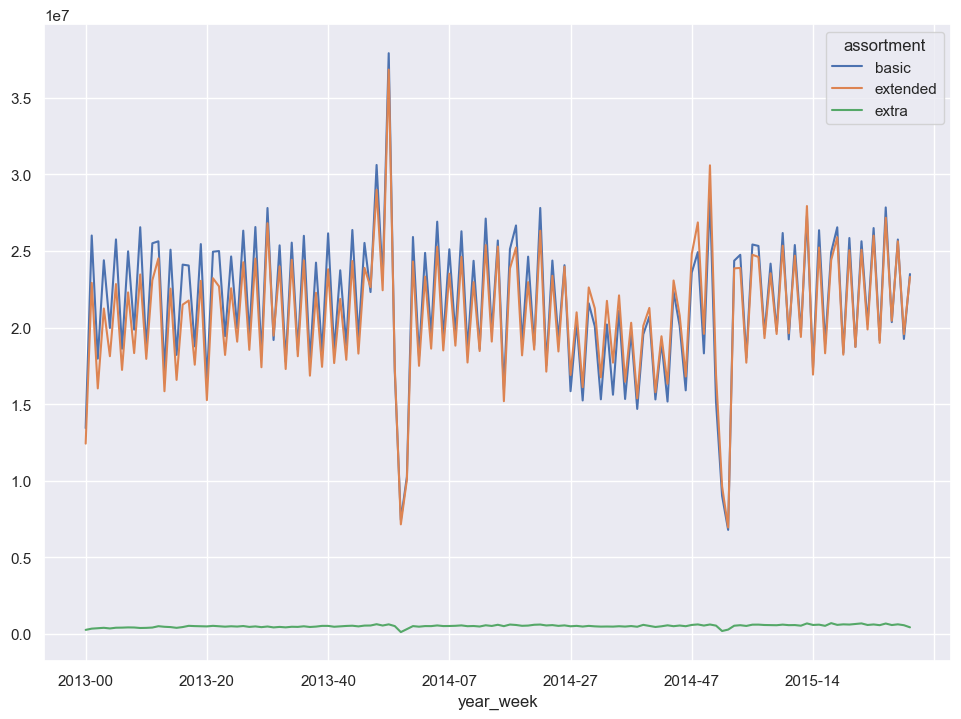

In [36]:
df_h1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y= 'sales', data = df_h1);

df_h1_2 = df4[['year_week' ,'assortment', 'sales']].groupby(['assortment', 'year_week']).sum().reset_index()
df_h1_2.pivot(index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();




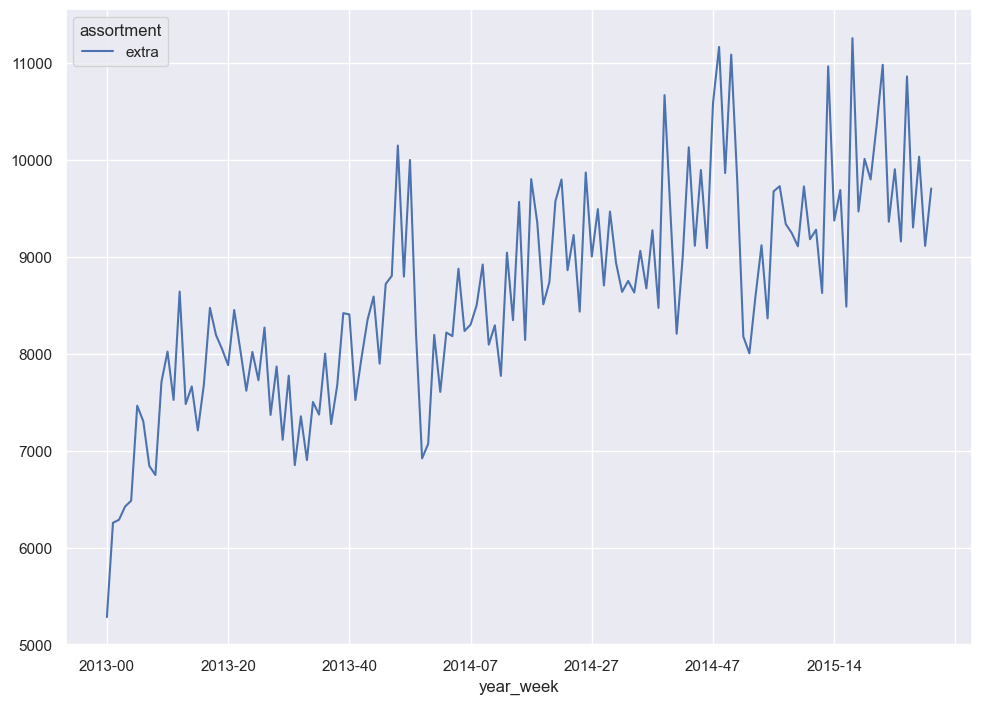

In [37]:
df_h1_3 = df4[df4['assortment'] == 'extra'].reset_index()
df_h1_3.pivot_table(index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.

- **FALSA**: Lojas com competidores próximos vendem mais

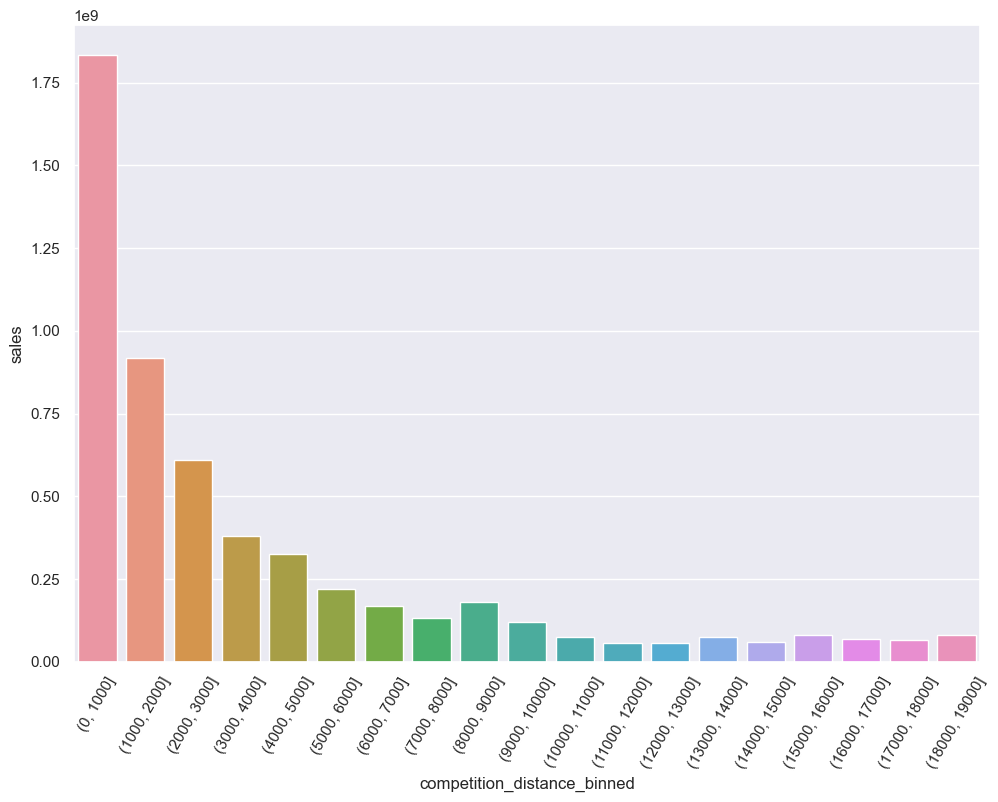

In [38]:
h2 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


bins = list(np.arange(0, 20000, 1000))
h2['competition_distance_binned'] = pd.cut(h2['competition_distance'], bins=bins) 
h2_2 = h2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y='sales', data=h2_2)
plt.xticks(rotation=60);

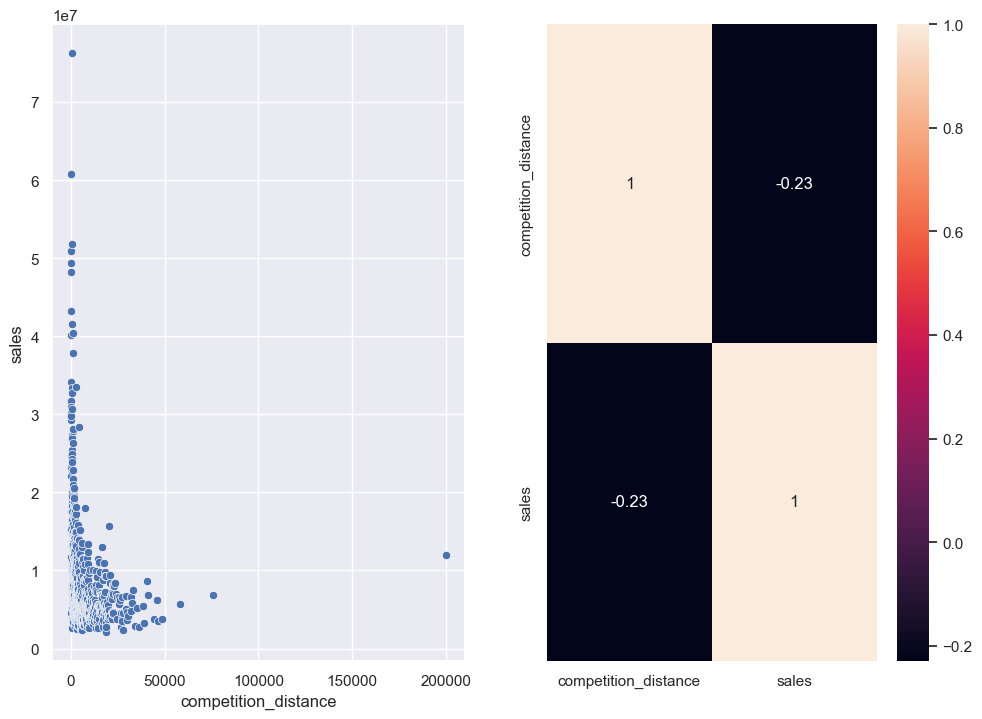

In [39]:
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=h2)

plt.subplot(1, 2, 2)
corr = h2[['competition_distance', 'sales']]
corr = corr.corr()
sns.heatmap(corr, annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.

- ***FALSA:*** Lojas com competidores a mais tempo vendem menos, a venda é maior quanto mais recente é a competição


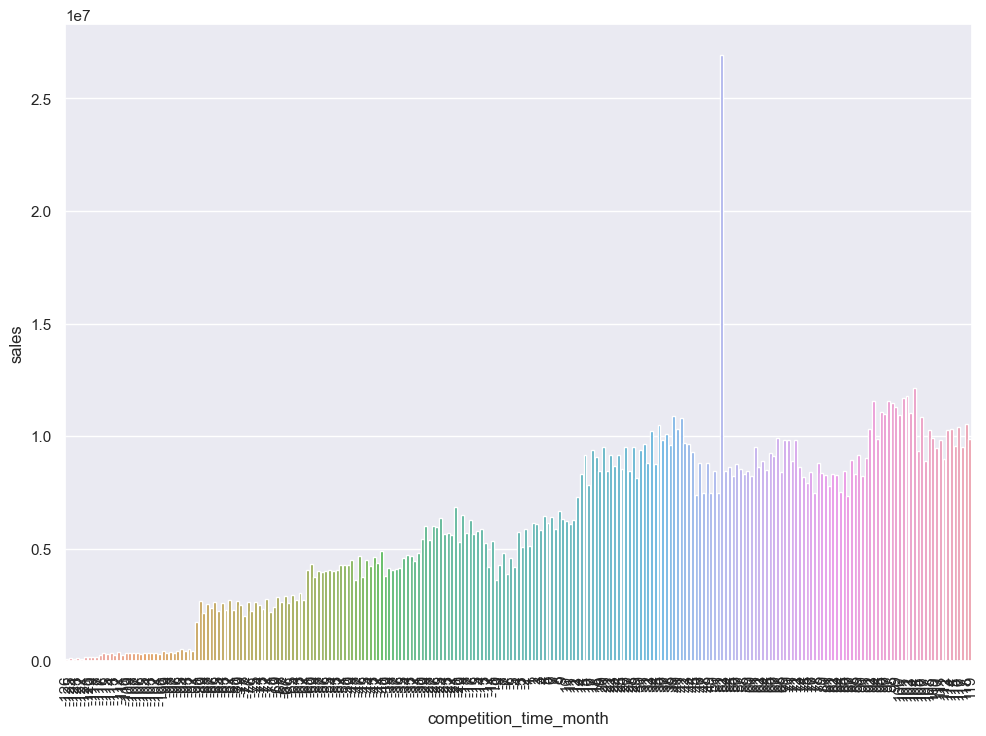

In [40]:
h3 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
h3_1 = h3[(h3['competition_time_month'] < 120) & (h3['competition_time_month'] != 0)]
sns.barplot(data=h3_1, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

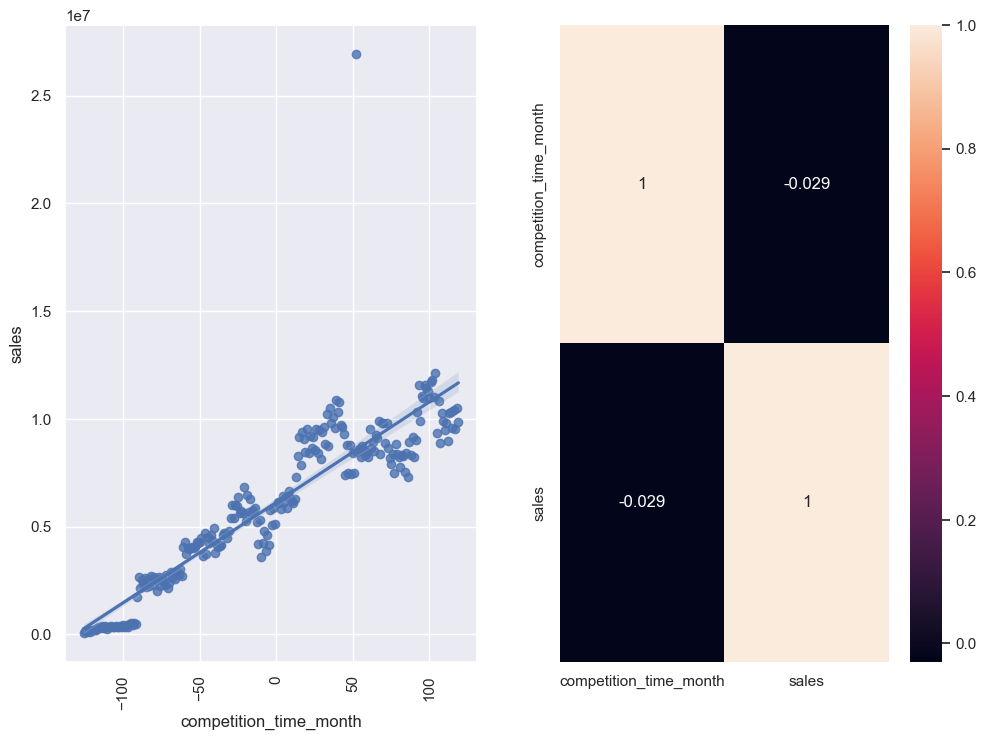

In [41]:
plt.subplot(1, 2, 1)
sns.regplot(data=h3_1, x='competition_time_month', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.heatmap(h3[['competition_time_month', 'sales']].corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

- ***FALSA:*** Lojas com promoções ativas a mais tempo, vendem menos, após certo período de promoção.


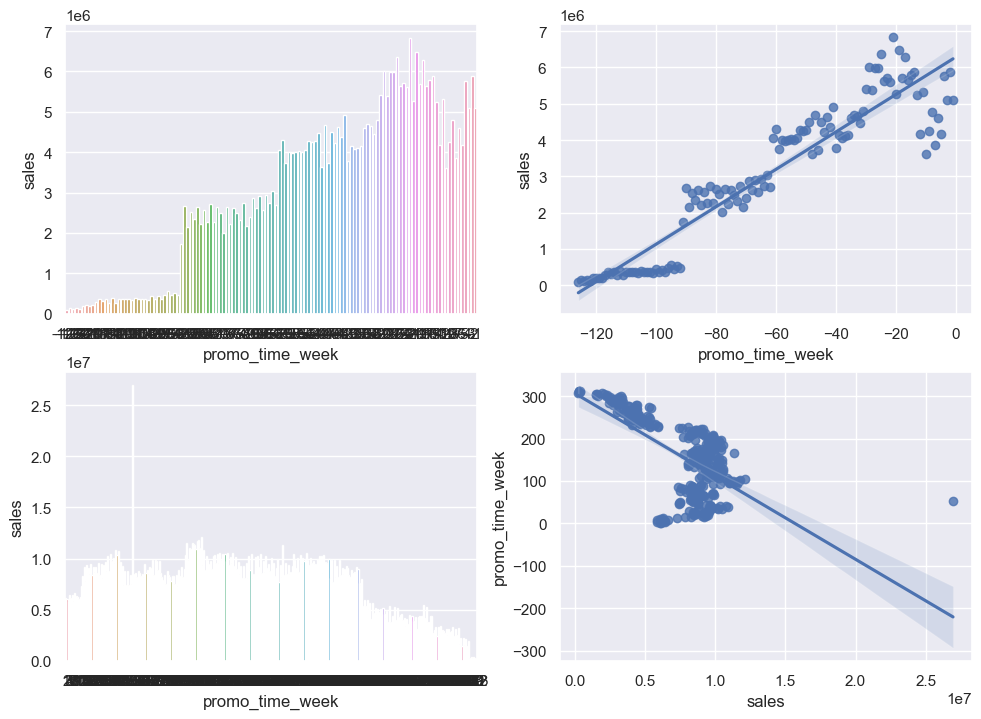

In [42]:
h4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 2, 1)
h4_2 = h4[h4['promo_time_week'] < 0]
sns.barplot(data = h4_2, x='promo_time_week', y='sales')

plt.subplot(2, 2, 2)
sns.regplot(data = h4_2, x='promo_time_week', y='sales')

plt.subplot(2, 2, 3)
h4_3 = h4[h4['promo_time_week'] > 0]
sns.barplot(data = h4_3, x='promo_time_week', y='sales')


plt.subplot(2, 2, 4)
sns.regplot(data = h4_3, y= 'promo_time_week', x='sales');

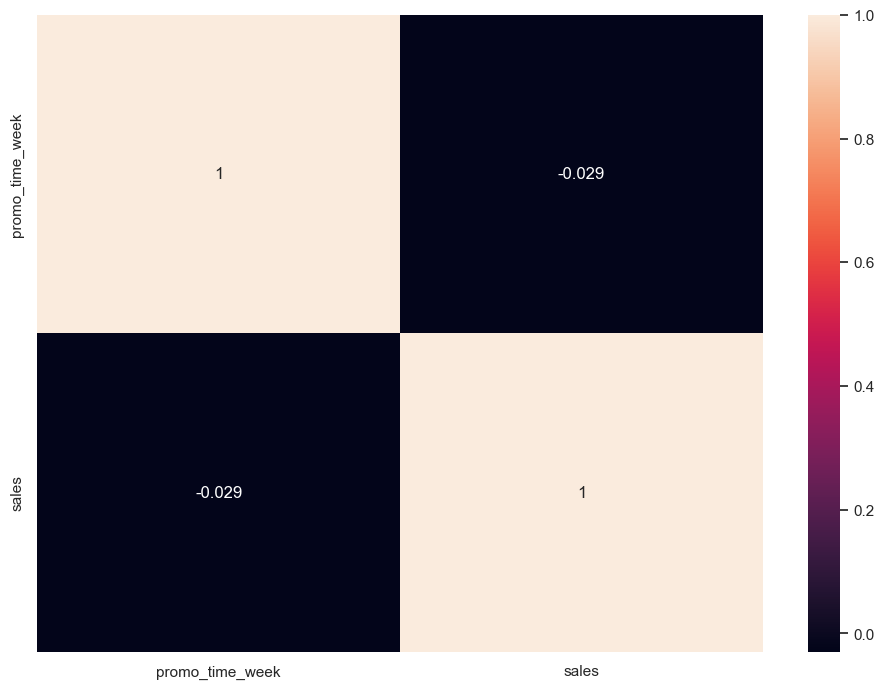

In [43]:
sns.heatmap(h4[['promo_time_week', 'sales']].corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

- ***FALSA**: Lojas com mais promoções consecutivas vendem menos

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


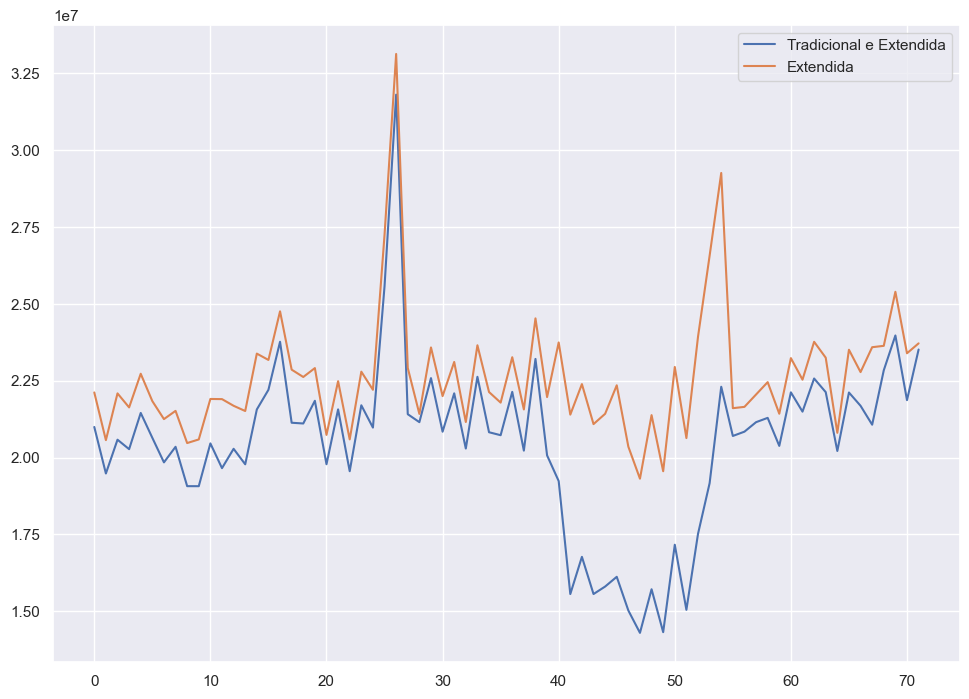

In [45]:
h4 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
h4 = h4.plot()

h4_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
h4_2.plot(ax=h4)

h4.legend(labels=['Tradicional e Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais que os outros feriados juntos

- ***FALSA:*** Lojas abertas no nata vendem menos.


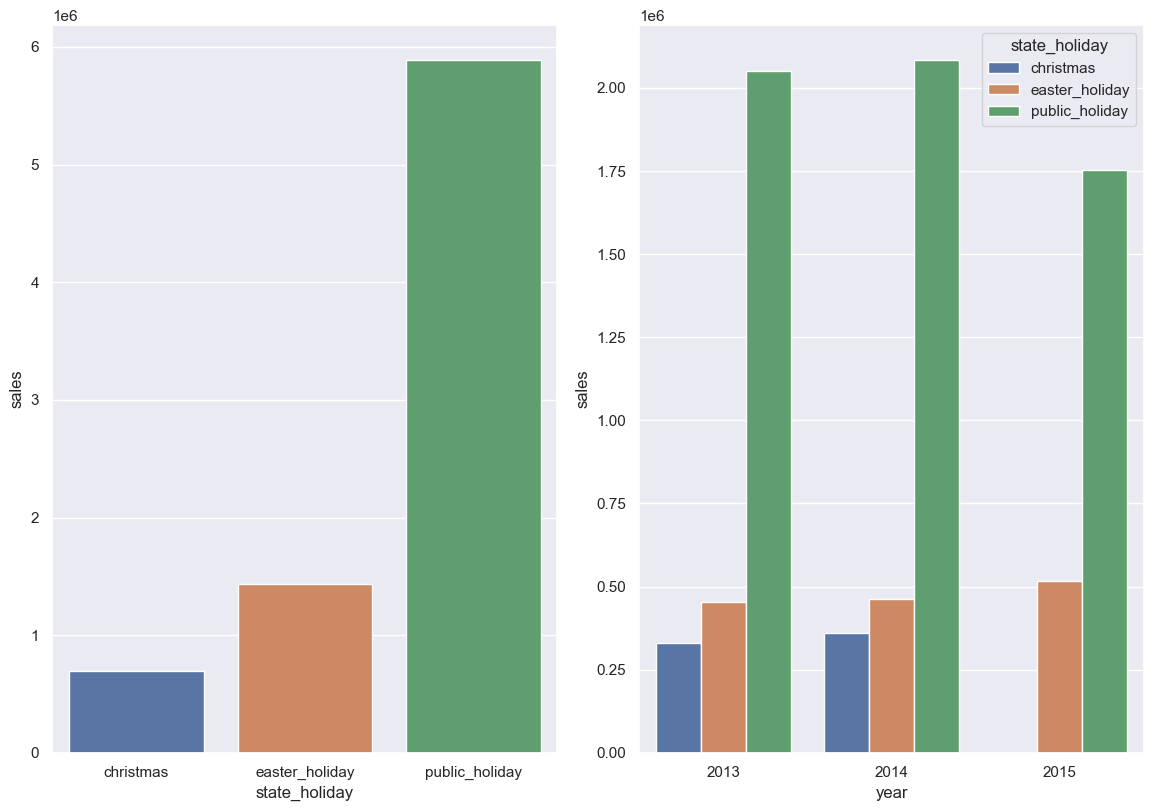

In [48]:
h7 = df4[df4['state_holiday'] != 'regular']

plt.subplot(1, 2, 1)
h7_1 = h7[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = h7_1, x='state_holiday', y='sales')
plt.tight_layout()

plt.subplot(1, 2, 2)
h7_2 = h7[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(data = h7_2, x='year', y='sales', hue='state_holiday')
plt.tight_layout();

### H8. Lojas deveriam vender mais ao longo dos anos.

- ***FALSA:*** Lojas vendem menos ao longo dos anos


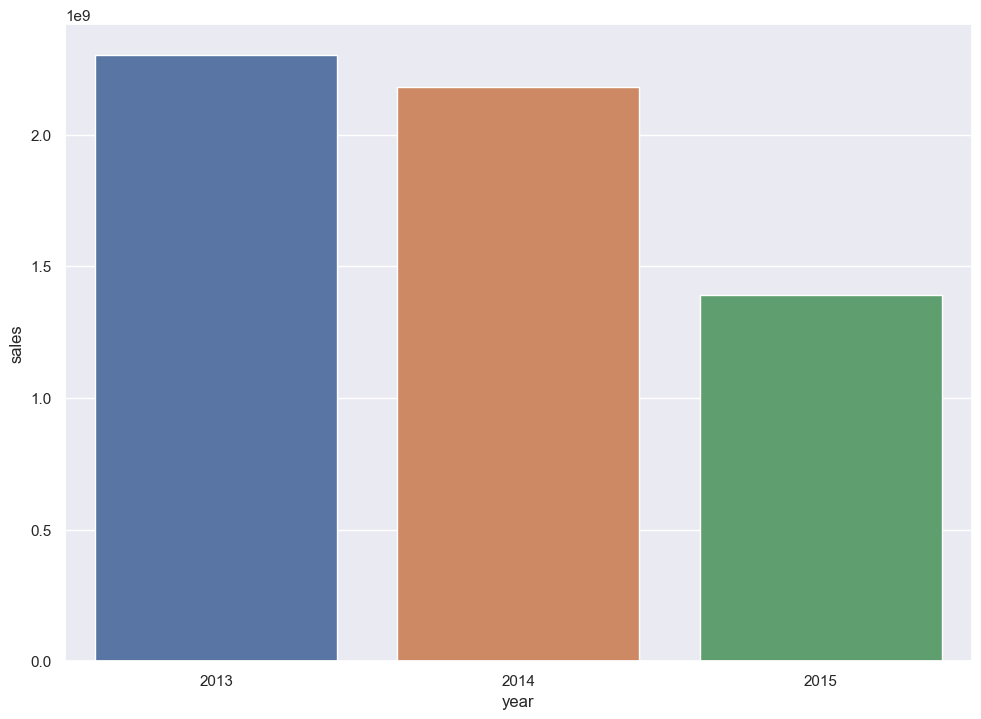

In [49]:
h8 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(data=h8, x='year', y='sales');

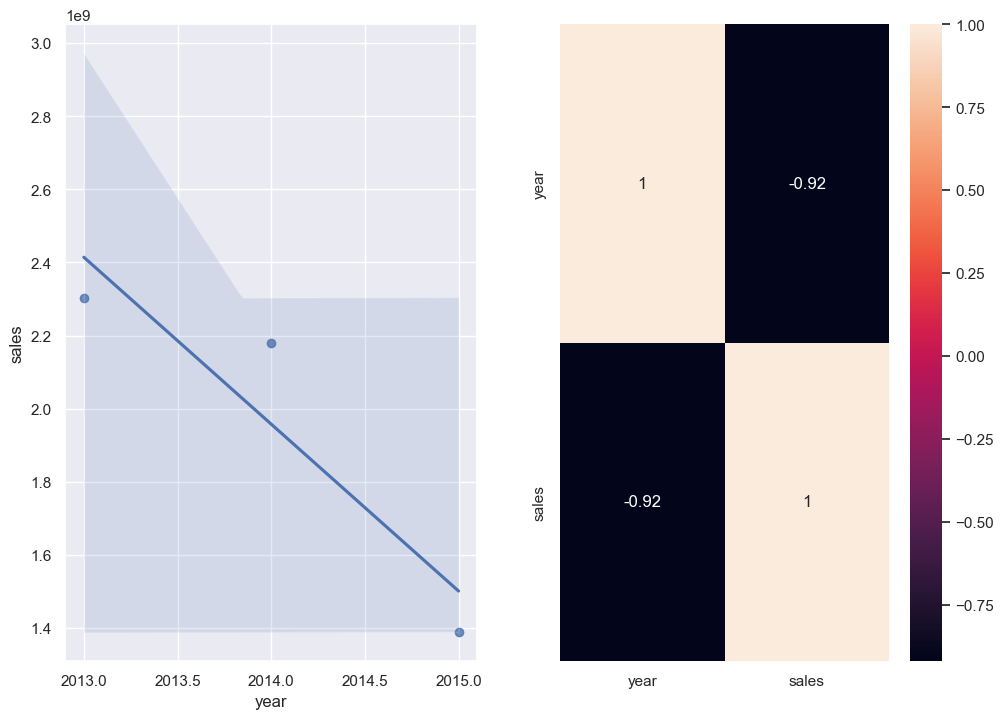

In [52]:
plt.subplot(1, 2, 1)
sns.regplot(data=h8, x='year', y='sales')


plt.subplot(1, 2, 2)
sns.heatmap(h8.corr(method='pearson'), annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.

- ***FALSE:*** Lojas vendem menos no segundo semestre do ano


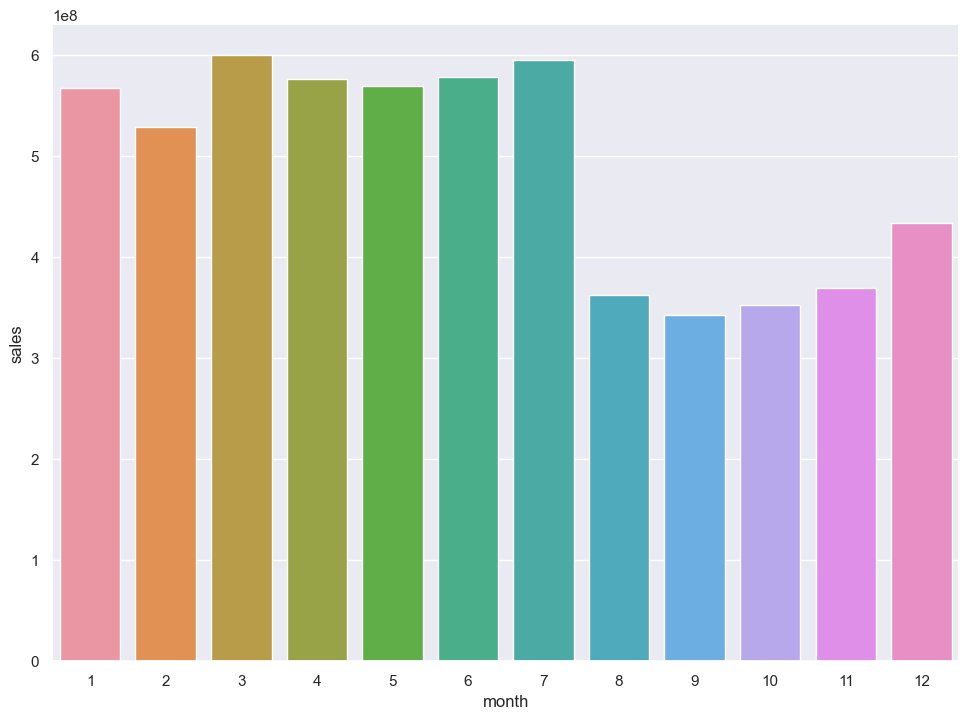

In [53]:
h9 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(data=h9, x='month', y='sales');

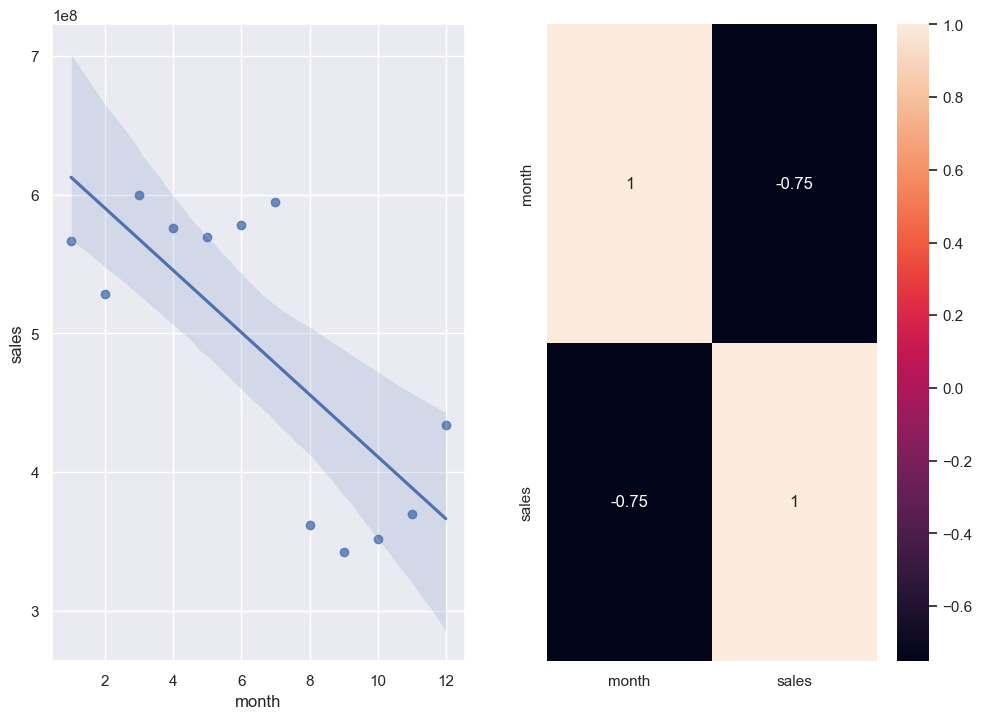

In [54]:
plt.subplot(1, 2, 1)
sns.regplot(data=h9, x='month', y='sales')


plt.subplot(1, 2, 2)
sns.heatmap(h9.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

- ***VERDADEIRA:*** Lojas vendem mais após o dia 10 de cada mês


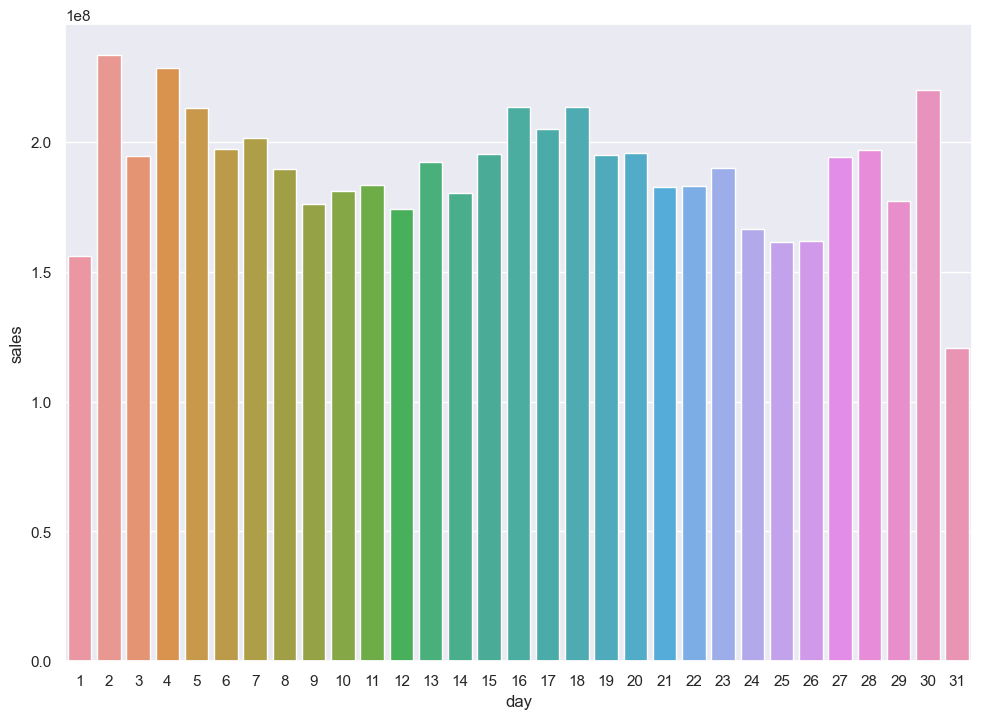

In [55]:
h10 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(data=h10, x='day', y='sales');

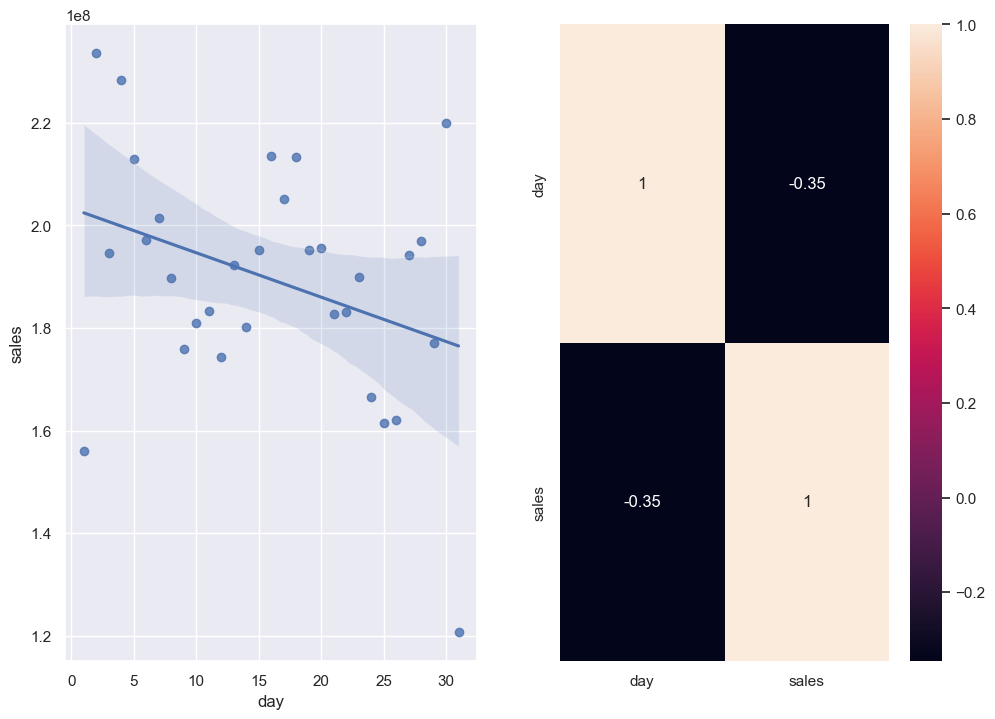

In [56]:
plt.subplot(1, 2, 1)
sns.regplot(data=h10, x='day', y='sales')

plt.subplot(1, 2, 2)
sns.heatmap(h10.corr(method='pearson'), annot=True);

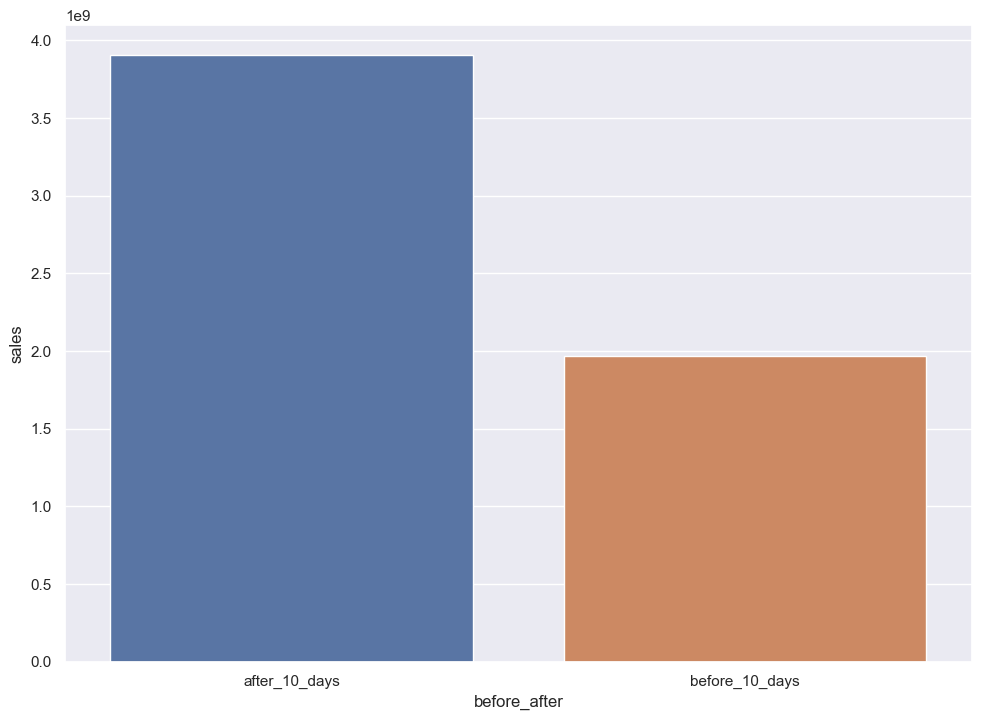

In [57]:
h10['before_after'] = h10['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

h10_2 = h10[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=h10_2, x='before_after', y='sales');

### H11. Lojas deveriam vender menos aos finais de semana

- ***FALSA:*** Lojas vendem menos aos finais de semana

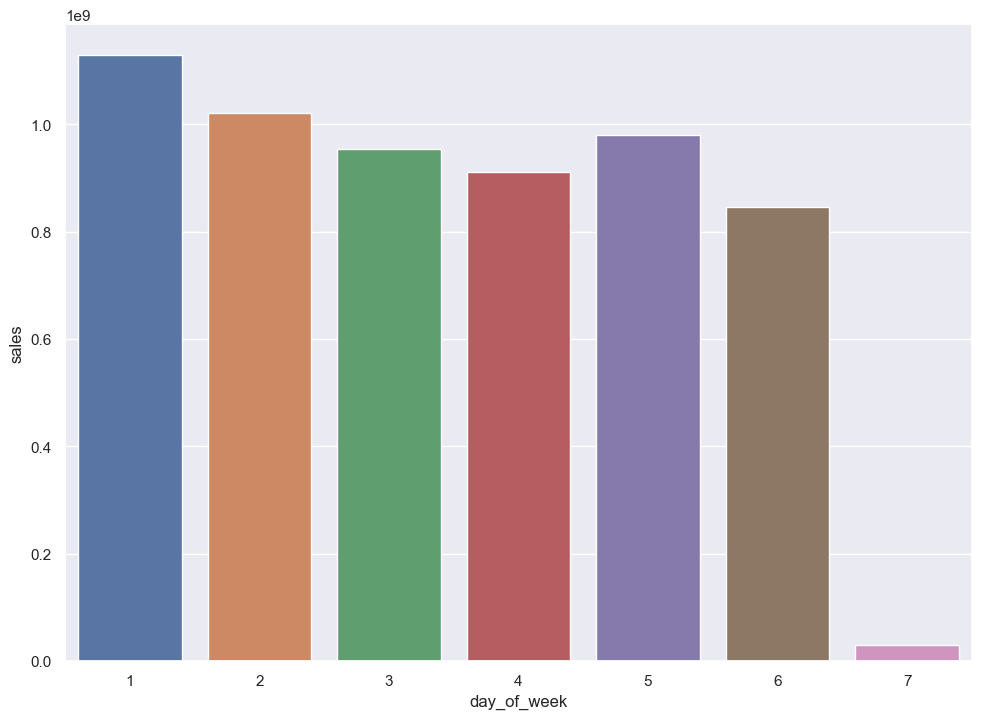

In [58]:
h11 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data=h11, x='day_of_week', y='sales');

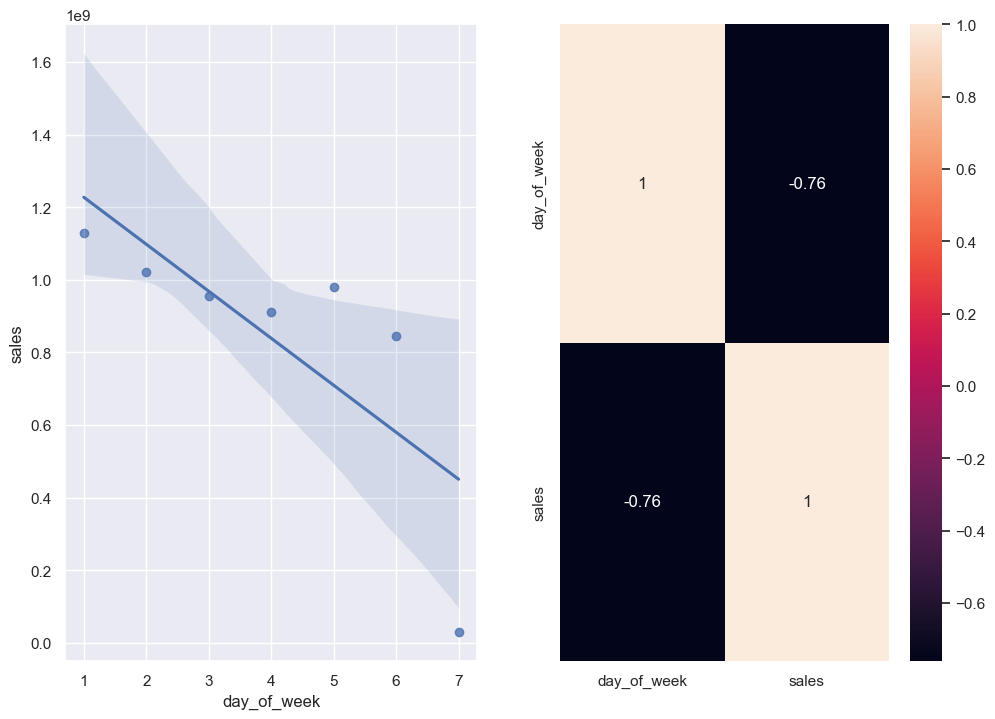

In [59]:
plt.subplot(1, 2, 1)
sns.regplot(data=h11, x='day_of_week', y='sales')

plt.subplot(1, 2, 2)
sns.heatmap(h11.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares

- ***VERDADEIRA:*** Lojas vendem menos em feriados escolares

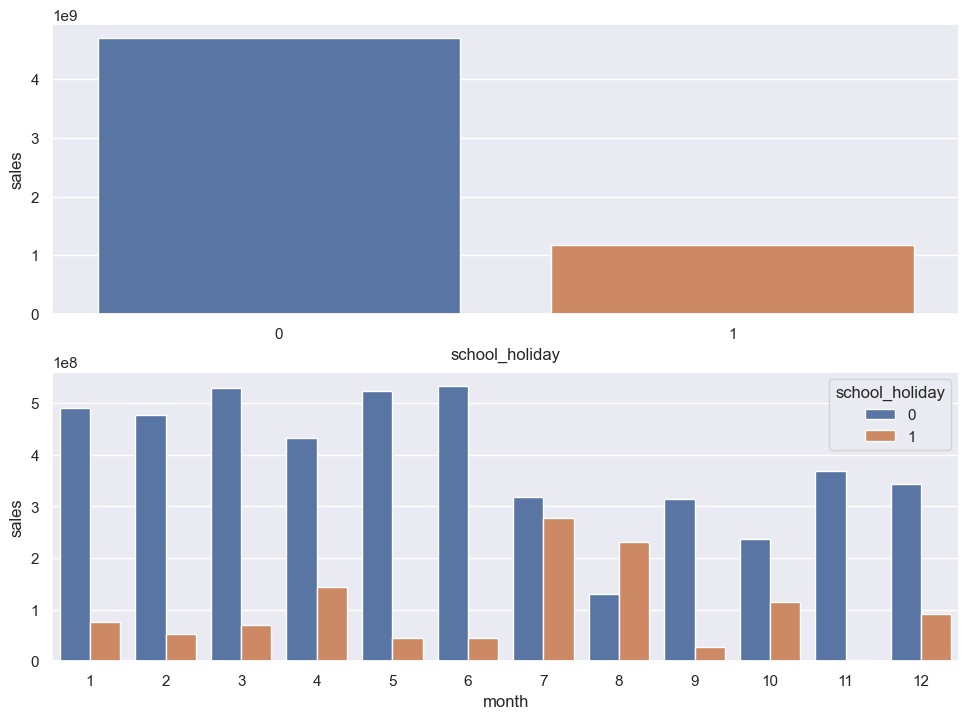

In [60]:
h12 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(data=h12, x='school_holiday', y='sales')

plt.subplot(2, 1, 2)
h12_1 = df4[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(data = h12_1, x='month', y='sales', hue='school_holiday');

## 4.3 Análise Multivariada

### 4.3.1 - Numerical Atributes

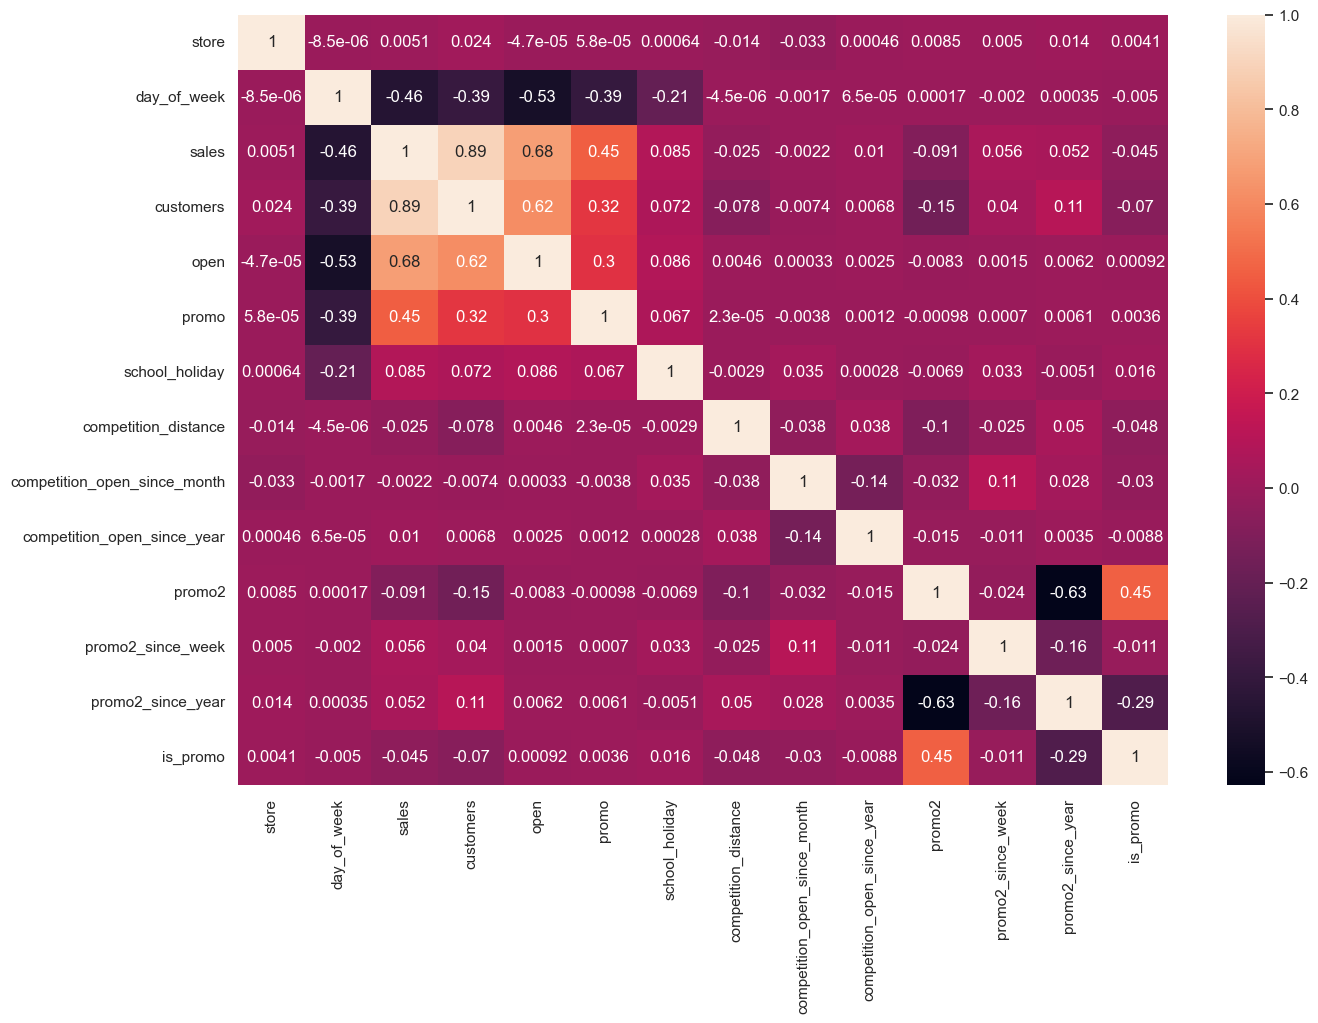

In [70]:
correlation = num_attributes.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlation, annot=True);

### 4.3.1 - Categorical Atributes

<Axes: >

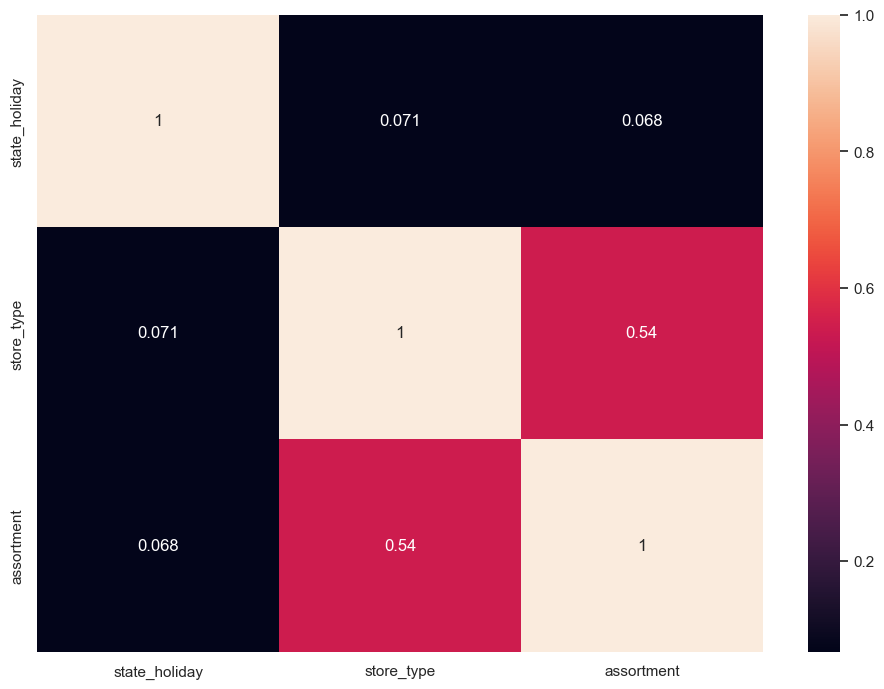

In [81]:
cat = df4.select_dtypes(include=['object'])
cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)

        else:
            cat_dic[c1].append(v)


cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)


sns.heatmap(cramer_v_table, annot=True)